<a href="https://colab.research.google.com/github/wenqiglantz/edd-recursive-doc-agent-vs-metadata-replacement/blob/main/edd_zephyr_7b_gpt3_5_metadata_replacement_multi_doc_deep_dive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluation Driven Development for Multi Document RAG Pipeline with GPT-3.5 and Zephyr-7b

This notebook demonstrates how to use EDD to decide which of the two LLMs perform best for a multi document RAG pipeline for Metadata replacement + node sentence window:


*   gpt-3.5-turbo
*   zephyr-7b-alpha

Suggest to upgrade to Colab Pro to run on T4 high-RAM. I tried to run on the free tier T4 GPU but failed during the download of Zephyr-7b.


## Why EDD?

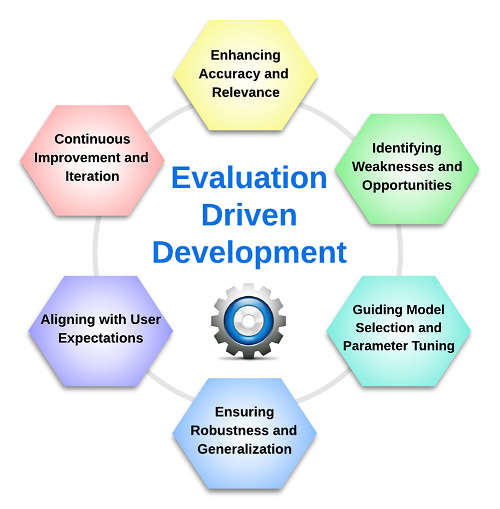

* **Enhancing Accuracy and Relevance**: EDD helps in identifying and addressing potential issues with the pipeline's output, ensuring that the generated responses are accurate, relevant, and consistent with the provided context.

* **Identifying Weaknesses and Opportunities**: EDD facilitates the detection of areas where the pipeline can be improved, allowing developers to focus on specific aspects that require refinement. This continuous evaluation process leads to overall performance optimization.

* **Guiding Model Selection and Parameter Tuning**: By evaluating different models and parameter configurations, EDD guides the selection of the most suitable model architecture and hyperparameters for the specific task at hand.

* **Ensuring Robustness and Generalization**: EDD ensures that the pipeline performs consistently across a variety of input scenarios and data distributions, enhancing its robustness and generalization capabilities.

* **Aligning with User Expectations**: EDD helps in aligning the pipeline's output with user expectations and requirements, ensuring that the generated responses are tailored to the specific needs of the target audience.

* **Continuous Improvement and Iteration**: EDD promotes a culture of continuous improvement and iteration, enabling developers to make informed decisions based on objective evaluation metrics.

In summary, EDD facilitates continuous improvement and optimization, and it plays a critical role in the development of high-quality RAG pipelines by ensuring that the generated responses are accurate, relevant, and aligned with user expectations.

## How to Implement EDD?

1. Use DatasetGenerator to auto-generate evaluation questions.
2. Define evaluators for faithfulness, relevancy, etc.
3. Use BatchEvalRunner to asynchronously run evaluations of the responses.
4. Compare the evaluation results.


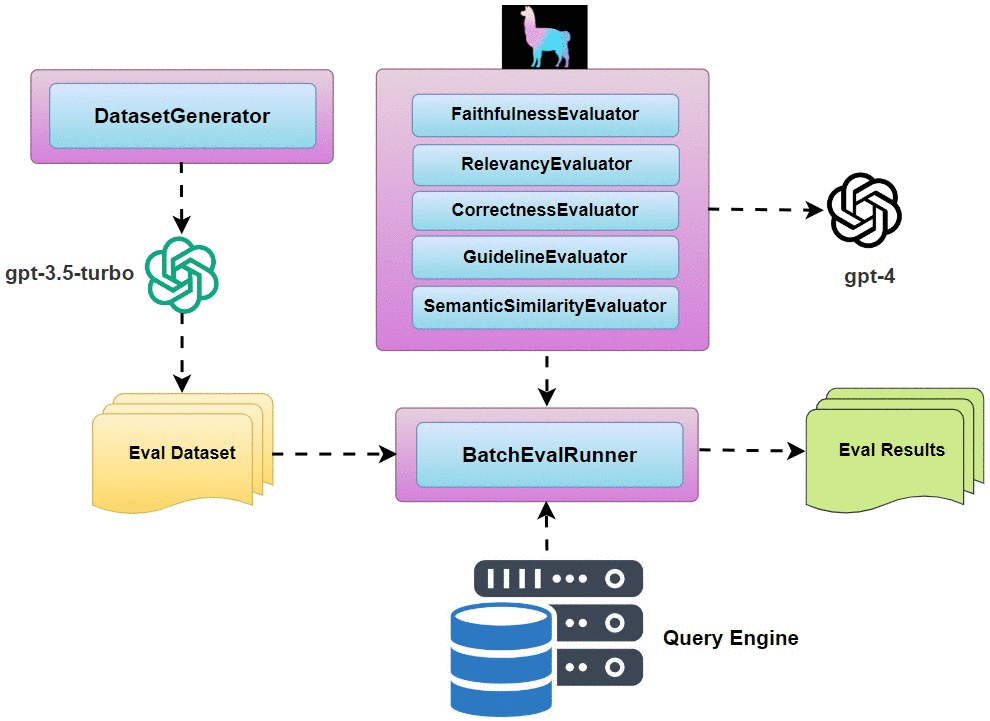

In [1]:
!pip install llama_index==0.8.45.post1 pypdf sentence-transformers transformers accelerate bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.0/755.0 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.6/276.6 kB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 11.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 95.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 87.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 88.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 86.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 37.2 MB/

## POC with Metadata Replacement + Node Sentence Window

SentenceWindowNodeParser is a tool that can be used to create representations of sentences that consider the surrounding words and sentences. During retrieval, before passing the retrieved sentences to the LLM, the single sentences are replaced with a window containing the surrounding sentences using the MetadataReplacementNodePostProcessor. This can be useful for tasks such as machine translation or summarization, where it is essential to understand the meaning of the sentence in its entirety. This is most useful for large documents, as it helps to retrieve more fine-grained details.

### Load documents

In [2]:
from llama_index import SimpleDirectoryReader

titles = [
    "DevOps_Self-Service_Pipeline_Architecture",
    "DevOps_Self-Service_Terraform_Project_Structure",
    "DevOps_Self-Service_Pipeline_Security_Guardrails"
    ]

documents = {}
for title in titles:
    documents[title] = SimpleDirectoryReader(input_files=[f"./data/{title}.pdf"]).load_data()
print(f"loaded documents with {len(documents)} documents")

loaded documents with 3 documents


### Set up node parser, service context

In [3]:
from llama_index import ServiceContext, set_global_service_context
from llama_index.llms import OpenAI
from llama_index.embeddings import OpenAIEmbedding, HuggingFaceEmbedding
from llama_index.node_parser import SentenceWindowNodeParser, SimpleNodeParser

# create the sentence window node parser
node_parser = SentenceWindowNodeParser.from_defaults(
    window_size=3,
    window_metadata_key="window",
    original_text_metadata_key="original_text",
)
simple_node_parser = SimpleNodeParser.from_defaults()

[nltk_data] Downloading package punkt to /tmp/llama_index...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## gpt-3.5-turbo

### Extract nodes and build index

In [4]:
import os, openai, logging, sys

os.environ["OPENAI_API_KEY"] = "sk-#################################"
openai.api_key = os.environ["OPENAI_API_KEY"]

logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)

In [5]:
#define LLM and embedding model
llm = OpenAI(model="gpt-3.5-turbo", temperature=0.1)
ctx = ServiceContext.from_defaults(
    llm=llm,
    embed_model="local:BAAI/bge-base-en-v1.5"
)

from llama_index import VectorStoreIndex

# extract nodes and build index
document_list = SimpleDirectoryReader("data").load_data()
nodes = node_parser.get_nodes_from_documents(document_list)
sentence_index = VectorStoreIndex(nodes, service_context=ctx)

### Define query engine

In [6]:
from llama_index.indices.postprocessor import MetadataReplacementPostProcessor

metadata_query_engine = sentence_index.as_query_engine(
    similarity_top_k=2,
    # the target key defaults to `window` to match the node_parser's default
    node_postprocessors=[
        MetadataReplacementPostProcessor(target_metadata_key="window")
    ]
)

### Run test queries

In [7]:
response = metadata_query_engine.query("Give me a summary of DevOps self-service-centric pipeline security and guardrails.")
print(str(response))

DevOps self-service-centric pipeline security and guardrails involve implementing a set of actions to ensure the security of pipelines, infrastructure, source code, base images, and dependent libraries. These actions are hand-picked and aim to provide measures and guardrails to protect the DevOps self-service environment. The goal is to establish a secure and reliable system that allows teams to independently manage and deploy their applications while adhering to security best practices.


In [8]:
response = metadata_query_engine.query("What is Harden Runner in DevOps self-service-centric pipeline security and guardrails?")
print(str(response))

Harden-Runner is a purpose-built security monitoring agent for pipelines in DevOps self-service-centric pipeline security and guardrails. It automatically discovers and correlates outbound traffic with each step in the pipeline to detect and prevent malicious patterns. It also prevents the exfiltration of credentials in the pipeline.


## zephyr-7b-alpha

In [9]:
import logging

logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)

In [10]:
import torch
from transformers import BitsAndBytesConfig
from llama_index.prompts import PromptTemplate
from llama_index.llms import HuggingFaceLLM

# load a model in 4bit using NF4 quantization with double quantization with the compute dtype bfloat16 for faster training
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)


def messages_to_prompt(messages):
  prompt = ""
  for message in messages:
    if message.role == 'system':
      prompt += f"<|system|>\n{message.content}</s>\n"
    elif message.role == 'user':
      prompt += f"<|user|>\n{message.content}</s>\n"
    elif message.role == 'assistant':
      prompt += f"<|assistant|>\n{message.content}</s>\n"

  # ensure we start with a system prompt, insert blank if needed
  if not prompt.startswith("<|system|>\n"):
    prompt = "<|system|>\n</s>\n" + prompt

  # add final assistant prompt
  prompt = prompt + "<|assistant|>\n"

  return prompt


llm_zephyr = HuggingFaceLLM(
    model_name="HuggingFaceH4/zephyr-7b-alpha",
    tokenizer_name="HuggingFaceH4/zephyr-7b-alpha",
    query_wrapper_prompt=PromptTemplate("<|system|>\n</s>\n<|user|>\n{query_str}</s>\n<|assistant|>\n"),
    context_window=3900,
    max_new_tokens=256,
    model_kwargs={"quantization_config": quantization_config},
    generate_kwargs={"temperature": 0.7, "top_k": 50, "top_p": 0.95},
    messages_to_prompt=messages_to_prompt,
    device_map="auto",
)

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [11]:

from llama_index import ServiceContext

service_context_zephyr = ServiceContext.from_defaults(
    llm=llm_zephyr,
    embed_model="local:BAAI/bge-base-en-v1.5"
)

### Extract nodes and build index

In [12]:
from llama_index import VectorStoreIndex

document_list = SimpleDirectoryReader("data").load_data()
nodes = node_parser.get_nodes_from_documents(document_list)
sentence_index_zephyr = VectorStoreIndex(nodes, service_context=service_context_zephyr)

### Define query engine

In [13]:
from llama_index.indices.postprocessor import MetadataReplacementPostProcessor

metadata_query_engine_zephyr = sentence_index_zephyr.as_query_engine(
    similarity_top_k=2,
    # the target key defaults to `window` to match the node_parser's default
    node_postprocessors=[
        MetadataReplacementPostProcessor(target_metadata_key="window")
    ]
)

### Run test queries

In [14]:
query = "Give me a summary of DevOps self-service-centric pipeline security and guardrails."
response = metadata_query_engine_zephyr.query(query)
print(str(response))

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1421: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:367: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should se

The article discusses DevOps self-service-centric pipeline security and guardrails, providing a list of hand-picked actions for security scans and guardrails for pipelines, infrastructure, source code, base images, and dependent libraries. The author acknowledges that coming from a traditional DevOps mindset, security measures and guardrails may be a concern. The article is part of a series that explores DevOps self-service pipeline architecture, Terraform project structure, and GitHub Actions workflow orchestration.


In [15]:
query = "What is Harden Runner in DevOps self-service-centric pipeline security and guardrails?"
response = metadata_query_engine_zephyr.query(query)
print(str(response))

Harden Runner is a purpose-built security monitoring agent for pipelines that automatically discovers and correlates outbound traffic with each step in the pipeline to detect and prevent malicious patterns observed during past software supply chain security breaches. It is used in all pipelines, including infrastructure and application pipelines for CI and CD, and is the only action used in all pipelines due to its unique nature and purpose. Its main features include preventing exfiltration of credentials in the pipeline.


## Evaluations

1. Use DatasetGenerator to auto-generate evaluation questions.
2. Define evaluators for faithfulness and relevancy.
3. Use BatchEvalRunner to asynchronously run evaluations of the responses.
4. Compare the evaluation results.

### Generate evaluation questions

In [26]:
import random
random.seed(42)
from llama_index.evaluation import DatasetGenerator
import nest_asyncio

nest_asyncio.apply()

# load data
document_list = SimpleDirectoryReader("data").load_data()

question_dataset = []
if os.path.exists("question_dataset.txt"):
    with open("question_dataset.txt", encoding='utf-8') as f:
        for line in f:
            question_dataset.append(line.strip())
else:
    # generate questions
    data_generator = DatasetGenerator.from_documents(document_list)
    generated_questions = data_generator.generate_questions_from_nodes()
    print(f"Generated {len(generated_questions)} questions.")

    # randomly pick 30 questions
    generated_questions = random.sample(generated_questions, 30)
    question_dataset.extend(generated_questions)
    print(f"Randomly picked {len(question_dataset)} questions.")

    # save the questions into a txt file
    with open("question_dataset.txt", "w") as f:
        for question in question_dataset:
            f.write(f"{question.strip()}\n")

for i, question in enumerate(question_dataset, start=1):
    print(f"{i}. {question}")

Generated 490 questions.
Randomly picked 30 questions.
1. What is the State of the Octoverse survey and when was it conducted?
2. What is the significance of having the Terraform code in the application's GitHub repository?
3. What is the significance of the 3-2-1 rule in the self-service pipeline architecture?
4. Why is it not recommended to have all Terraform code for all projects committed in one standalone repo?
5. What is the purpose of Infracost in a DevOps environment?
6. How do you enable the audit mode in Harden-Runner?
7. What is the significance of the Harden-Runner action in ensuring pipeline security?
8. How does image immutability drive the workflows in GitHub Actions?
9. What other files might be included in the file structure of a reusable module, depending on its complexity?
10. What is the file name of the document?
11. How do reusable Terraform modules make it easier to manage infrastructure?
12. How does the Terraform workflow handle the default branch if no apply-b

### Define evaluators

GPT-4 is the most advanced large language model currently available, and it can be used as a benchmark to compare the performance of other models. Compared to other models, GPT-4 is more accurate, creative, and efficient.

In [19]:
from llama_index.evaluation import FaithfulnessEvaluator, RelevancyEvaluator

# use gpt-4 to evaluate
gpt4_service_context = ServiceContext.from_defaults(llm=OpenAI(temperature=0.1, llm="gpt-4"))

faithfulness_gpt4 = FaithfulnessEvaluator(service_context=gpt4_service_context)
relevancy_gpt4 = RelevancyEvaluator(service_context=gpt4_service_context)

In [20]:
from llama_index import Response
import pandas as pd

def display_eval_df(query: str, response: Response, eval_result: str) -> None:
    if response.source_nodes == []:
        print("no response!")
        return
    eval_df = pd.DataFrame(
        {
            "Query": query,
            "Response": str(response),
            "Source": response.source_nodes[0].node.text[:500] + "...",
            "Evaluation Result": "Pass" if eval_result.passing else "Fail",
        },
        index = [0]
    )

    eval_df = eval_df.style.set_properties(
        **{
            "inline-size": "600px",
            "overflow-wrap": "break-word",
        },
        subset=["Response", "Source"]
    )
    display(eval_df)

In [21]:
for query in question_dataset:
    response = metadata_query_engine.query(query)
    eval_result = faithfulness_gpt4.evaluate_response(response=response)
    display_eval_df(query, response, eval_result)

### Define evaluation batch runner

In [22]:
from llama_index.evaluation import BatchEvalRunner

runner = BatchEvalRunner(
    {"faithfulness": faithfulness_gpt4, "relevancy": relevancy_gpt4},
    workers=8,
    show_progress=True
)

In [23]:
def get_eval_results(key, eval_results):
    results = eval_results[key]
    correct = 0
    for result in results:
        if result.passing:
            correct += 1
    score = correct / len(results)
    print(f"{key} Correct: {correct}. Score: {score}")
    return score

### Evaluation on gpt-3.5-turbo

In [24]:
eval_results = await runner.aevaluate_queries(
    metadata_query_engine, queries=question_dataset
)

print("------------------")
score = get_eval_results("faithfulness", eval_results)
score = get_eval_results("relevancy", eval_results)

100%|██████████| 60/60 [00:04<00:00, 12.57it/s]

------------------
faithfulness Correct: 29. Score: 0.9666666666666667
relevancy Correct: 28. Score: 0.9333333333333333


### Evaluation on zephyr-7b

In [25]:
eval_results = await runner.aevaluate_queries(
    metadata_query_engine_zephyr, queries=question_dataset
)

print("------------------")
score = get_eval_results("faithfulness", eval_results)
score = get_eval_results("relevancy", eval_results)

  0%|          | 0/30 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:367: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
100%|██████████| 60/60 [10:05<00:00, 10.10s/it]

------------------
faithfulness Correct: 28. Score: 0.9333333333333333
relevancy Correct: 28. Score: 0.9333333333333333


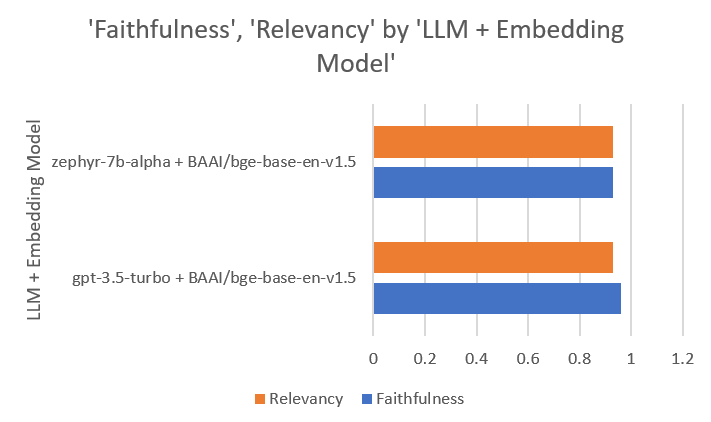